  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

60000
10000


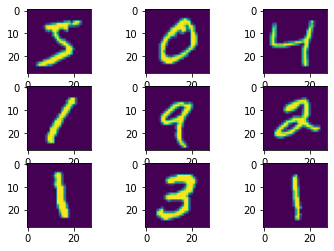

In [ ]:
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

# 학습용 데이터와 평가용 데이터 분리
# ToTensor() => 파이토치 텐서로 변환
training_data = MNIST(root="./", train=True, download=True, transform=ToTensor())
test_data = MNIST(root="./", train=False, download=True, transform=ToTensor())

print(len(training_data)) # 학습에 사용할 데이터 개수
print(len(test_data)) # 평가에 사용할 데이터 개수
for i in range(9): # 샘플 이미지 9개 출력
    plt.subplot(3, 3, i+1)
    plt.imshow(training_data.data[i])
plt.show()

In [ ]:
from torch.utils.data.dataloader import DataLoader

# 배치 크기 - 일반적으로 32 또는 64
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
# shuffle : 섞는다
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
# 손글씨 분류 모델 학습
import torch # 기본 파이토치
import torch.nn as nn # nn : 신경망

from torch.optim.adam import Adam # 최적화 함수 <- 가중치

In [ ]:
# 런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU (cuda) / cpu
# 엔비디아 GPU 처리
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# Sequential : 신경망들 배치 -> 이 순서대로 진행
# 784 입력층 -> 28px x 28px -> 한줄로 -> 784px
model = nn.Sequential(
    # 32, 64, 100, 200...?
    # 1. 임의로. (끌리는대로... 익숙한대로...)
    # 2. 하이퍼 패러미터 튜닝의 일종? : 입력층 - 데이터가 몇개 들어오는지?
    # 은닉층 : 영업비밀? <- 튜닝
    # 출력층 : <연속된값?> / <특성에 따라 분류>
    nn.Linear(784, 64), # 28px x 28px -> 784
    nn.ReLU(), # 활성화 함수 1
    nn.Linear(64, 64), # 배치 크기가 32였는데, 
    nn.ReLU(), # 활성화 함수 2
    nn.Linear(64, 10) # 최종적 0-9 10개 분류로...
)
model.to(device) # GPU

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
lr = 1e-3 # 학습률 : 가중치 변경 반영
# model.parameters <- 변수당 가중치 / lr <- 얼마만큼 (경사하강법) 반영
optim = Adam(model.parameters(), lr=lr) # 최적화 함수 : 가중치 업데이트

In [ ]:
# 학습
for epoch in range(20): # 에포크 20회
    # train_loader <- batch_size (32)
    for data, label in train_loader: # 32
        optim.zero_grad() # 반복 경사(가중치 경사) 초기화
        # data # 28 x 28 => 784 => tensor => torch
        # -1 => 배치 크기만큼 하겠다 => (32)
        # (32, 28, 28) -> (32, 784)
        data = torch.reshape(data, (-1, 784)).to(device)
        preds = model(data) # 모델에 넣어줘서 예측
        # 회귀 : MSE / 분류 : CrossEntropy <- 손실
        # 보스턴 집값 예측 aka 선형회귀 -> nn.MSELoss.
        # 다중분류 : 2개이상~ / CrossEntropyLoss : 손실함수
        loss = nn.CrossEntropyLoss()(preds, label.to(device)) # 손실 계산
        loss.backward() # 오차 역전파 - 경사
        optim.step() # 최적화 <- 가중치 업데이트
    print(f"epoch{epoch+1} loss : {loss.item()}")

torch.save(model.state_dict(), "MNIST.pth")

epoch1 loss : 0.3096979856491089
epoch2 loss : 0.059079259634017944
epoch3 loss : 0.06597369909286499
epoch4 loss : 0.15438547730445862
epoch5 loss : 0.052898257970809937
epoch6 loss : 0.11692489683628082
epoch7 loss : 0.049366310238838196
epoch8 loss : 0.05835121497511864
epoch9 loss : 0.10373011231422424
epoch10 loss : 0.010687557980418205
epoch11 loss : 0.04578252509236336
epoch12 loss : 0.005072593688964844
epoch13 loss : 0.1320239007472992
epoch14 loss : 0.05009996145963669
epoch15 loss : 0.0267501138150692
epoch16 loss : 0.0006614538142457604
epoch17 loss : 0.0660591721534729
epoch18 loss : 0.00030788639560341835
epoch19 loss : 0.007360702846199274
epoch20 loss : 0.00012402252468746156


In [ ]:
!ls

MNIST  MNIST.pth  sample_data


In [ ]:
# 1 모델 가중치 불러오기
model.load_state_dict(torch.load("MNIST.pth", map_location=device))

num_corr = 0 # 분류에 성공한 전체 개수

with torch.no_grad(): # 2 기울기를 계산하지 않음
    for data, label in test_loader: # 32
        # 32, 28, 28 -> 32, 784
        data = torch.reshape(data, (-1, 784)).to(device)
        
        output = model(data.to(device))
        # print(output.data) # 예측한 값들의 목록
        # print(output.data.max(1)) # max(1) : 0~9 사이에서 가장 높은 확률을 가진걸 뽑아주겠다
        # 0, 1 => 0. 확률치 / 1. 분류 (0-9)
        # print(output.data.max(1)[0], output.data.max(1)[1])
        preds = output.data.max(1)[1] # 3 모델의 예측값 계산
        
        # 4 올바르게 분류한 개수
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr
        # print(num_corr)

print(f"Accuracy:{num_corr/len(test_data)}") # 분류 정확도 출력

Accuracy:0.975


In [ ]:
# [월]
# 윈도우 PC -> 주피터 노트북 -> 캠 -> 손글씨(0-9) 인식시키는 모델
# 카메라 사진 찍어서 -> 업로드 -> 맞추는지